In [1]:
import tensorflow as tf
import numpy as np 
import random 
import matplotlib.pyplot as plt 

In [2]:
# Defining some key methods

def label_to_output(label):
    o = [0]*10
    o[label] = 1
    return o

def sigmoid(x):
    return (1 / (1 + np.exp(-x)))

def d_sigmoid(x):
    return sigmoid(x) * (1-sigmoid(x))

In [3]:
# Load data, normalize, convert labels to array

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train, x_test = x_train/255, x_test/255

TRAIN_LENGTH = len(x_train) # 60000
TEST_LENGTH = len(x_test) # 10000

train_labels = np.zeros((TRAIN_LENGTH, 10))
for i, label in enumerate(y_train):
    train_labels[i] = (label_to_output(label))

test_labels = np.zeros((TEST_LENGTH, 10))
for i, label in enumerate(y_test):
    test_labels[i] = (label_to_output(label))

In [40]:
lr = 0.003
epochs = 1

batch_size = 1
train_loader = x_train.reshape(-1, batch_size, 28, 28)
label_loader = train_labels.reshape(-1, batch_size, 1, 10)

fcl_w = 2 * np.random.rand(784, 64) - 1 
fcl_b = 2 * np.random.rand(1,   64) - 1 

output_w = 2 * np.random.rand(64, 10) - 1 
output_b = 2 * np.random.rand(1,  10) - 1

for e in range(epochs):
    print(f'Epoch {e+1}:')
    # for i, batch in enumerate(train_loader):
    for i in range(1):
        label = label_loader[i]
        x = batch

        # Forward Pass
        layer_input = x.reshape(-1, 1, 784)
        
        z1 = np.matmul(layer_input, fcl_w) + fcl_b
        a1 = sigmoid(z1)
        
        z2 = np.matmul(z1, output_w) + output_b
        y  = sigmoid(z2)

        # Error computation
        output_error = (y - label)*d_sigmoid(z2)
        fcl_error    = np.matmul(output_error, output_w.transpose())*d_sigmoid(z1)

        loss = 0.5 * (1/batch_size) * np.sum((y-label)**2)

        print(z1.shape)
        print(np.einsum('ijk->ikj', output_error).shape)

        # Gradient descent
        output_w = output_w - (lr / batch_size) * np.sum(
                    np.matmul(np.einsum('ijk->ikj', output_error), z1), axis = 0).transpose()
        
        output_b = output_b - (lr / batch_size) * np.sum(
                    output_error, axis = 0)

        fcl_w = fcl_w - (lr / batch_size) * np.sum(
                    np.matmul(np.einsum('ijk->ikj', fcl_error), layer_input), axis = 0).transpose()

        fcl_b = fcl_b - (lr / batch_size) * np.sum(
                    fcl_error, axis = 0)
        
        # Cross validate
        every = 5 # times
        if (i+1)%((60000/batch_size)/every) == 0:
            layer_input = x_test.reshape(-1, 1, 784)
            
            z1 = np.matmul(layer_input, fcl_w) + fcl_b
            a1 = sigmoid(z1)
            
            z2 = np.matmul(z1, output_w) + output_b
            y  = sigmoid(z2)

            # test_loss = 0.5 * (1/10000) * np.sum((y-test_labels)**2)

            predictions = np.argmax(y, axis = 2)
            equals = predictions == y_test.reshape(10000, 1)
            accuracy = np.sum(equals)/10000

            print('Batch {}: Loss = {:.3}, CV accuracy = {:.2%}'.format(i+1, loss, accuracy))

Epoch 1:
(1, 1, 64)
(1, 10, 1)


In [17]:
layer_input = x_test.reshape(-1, 1, 784)
            
z1 = np.matmul(layer_input, fcl_w) + fcl_b
a1 = sigmoid(z1)

z2 = np.matmul(z1, output_w) + output_b
y  = sigmoid(z2)

# test_loss = 0.5 * (1/10000) * np.sum((y-test_labels)**2)

predictions = np.argmax(y, axis = 2)
equals = predictions == y_test.reshape(10000, 1)
accuracy = np.sum(equals)/10000

print('Loss = {:.3}, CV accuracy = {:.2%}'.format(loss, accuracy))


Loss = 0.853, CV accuracy = 12.67%
[[5.39527870e-06 3.80964835e-05 4.57664876e-08 9.14342968e-01
  3.20843450e-07 7.87396033e-01 3.93708041e-11 9.02713992e-12
  2.76011949e-10 2.18903524e-07]]
[3]


Text(0.5, 1.0, 'prediction: 0')

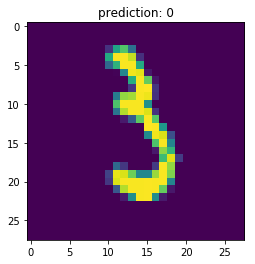

In [32]:
def predict(x):
    layer_input = x.reshape(-1, 1, 784)
 
    z1 = np.matmul(layer_input, fcl_w) + fcl_b
    a1 = sigmoid(z1)
    
    z2 = np.matmul(z1, output_w) + output_b
    y  = sigmoid(z2)

    predictions = np.argmax(y, axis = 2)
    return predictions[0][0]

index = 795
prediction = predict(x_test[index])

plt.imshow(x_test[index])
plt.title(f'prediction: {prediction}')

In [82]:
'''
MLN algorithm:: 

* Input: (m) x 1 x 784

* FCL:   64 neurons
* FCL_w: (784 x 64)
* FCL_b: (1 x 64)

* output layer: 10 neurons
* output_w:     (64 x 10)
* output_b:     (1 x 10)


Forward: 
* x -> Input                                    m x 1 x 784

* z1 = Input * FCL_w + FCL_b                    m x 1 x 64
* a1 = sigmoid(z1)

* z2 = z1 * output_w + output_b                 m x 1 x 10
* y  = sigmoid(z2)                              

Backward: 

Step 1: Error
* output_error  = (y - label) .* d_sigmoid(z2)                          m x 1 x 10

                   (m x 1 x 10)      (64 x 10)^T    m x 1 x 64
* FCL_error     = (output_error * output_w^T) .* (d_sigmoid(z1))        m x 1 x 64


Step 2: Gradient descent

                 (64 x 10)    constant           m x (1 x 10)^T   m x 1 x 64  
* output_w      = output_w - (alpha / m) * sum( output_error^T  *    z1      )^T     64 x 10

                  (1 x 10)    constant           m x 1 x 10
* output_b      = output_b - (alpha / m) * sum( output_error )

                 (784 x 64)   constant           m x (1 x 64)^T   m x 1 x 784  
* FCL_w         = FCL_w    - (alpha / m) * sum( FCL_error^T     *    Input   )^T    784 x 64

                  (1 x 10)    constant           m x 1 x 10
* FCL_b         = FCL_b    - (alpha / m) * sum( fcl_error )


'''

'''

1. Create batches
x_train.reshape(-1, batches, 28, 28) # maybe?

2. For each batch:

        forward pass
        calculate loss
        back propagation

        cross validate on (test_set)?
        test loss 
        test accuracy

'''

pass